## Evaluation of Geometric and Standard Methods

In [1]:
from ccaman.ccaman import CCAMan
ccaman = CCAMan()
ccaman.analyze()

Combining data 2
Wrote to file


In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Perform the analysis
# Pivot sensitivity data to have drugs as columns and cell lines as rows
sensitivity_pivot = ccaman.sensitivity_data.pivot(
    index="Cell Line", columns="Drug Name", values="Z Score"
)

# Align the gene expression data and drug sensitivity data by cell lines
gene_expression = (
    ccaman.genes_to_cellline.T
)  # transpose because the genes are in the rows
common_cell_lines = sensitivity_pivot.index.intersection(gene_expression.index)
sensitivity_pivot = sensitivity_pivot.loc[common_cell_lines]
gene_expression = gene_expression.loc[common_cell_lines]

# Normalize both datasets
scaler = StandardScaler()
X = scaler.fit_transform(gene_expression)  # Gene expression data
Y = scaler.fit_transform(sensitivity_pivot)  # Z Scores


In [3]:
# Print rows with Nan values for sensitivity data
nan_rows = np.isnan(Y).any(axis=1)
print("Rows with NaN values in sensitivity data")
print(sensitivity_pivot[nan_rows])

Rows with NaN values in sensitivity data
Drug Name  Alpelisib  Lapatinib  Olaparib  Palbociclib  Tamoxifen
HCC202           NaN        NaN       NaN     0.828654        NaN


In [4]:
sensitivity_pivot.shape # cell lines x drugs

(15, 5)

In [5]:
gene_expression.shape # cell lines x genes

(15, 36953)

In [6]:
# Check for NaNs in X and Y
print(f"Number of NaNs in X: {pd.DataFrame(X).isna().sum().sum()}")
print(f"Number of NaNs in Y: {pd.DataFrame(Y).isna().sum().sum()}")

# Substitute NaNs with 0 for 0 sensitivity
Y = np.nan_to_num(Y, nan=0)


Number of NaNs in X: 0
Number of NaNs in Y: 4


In [7]:
# Perform Canonical Correlation Analysis (CCA)
cca = CCA(n_components=5)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)

# Calculate the canonical correlation coefficients
correlations = np.corrcoef(X_c.T, Y_c.T)[:2, 2:]

print(f"Correlations: {correlations}")

Correlations: [[ 1.18500009e-15  1.84084629e-16  7.79500493e-16  1.00000000e+00
   2.42596988e-17  7.31730247e-16 -4.51857140e-16  7.07722689e-16]
 [-4.09771835e-16 -1.96552720e-16 -5.40452097e-17  2.26249476e-16
   1.00000000e+00 -8.13575225e-16 -5.77491821e-16  6.12291163e-16]]


Canonical Correlations: [0.9999999999999998, 1.0, 1.0, 0.9999999999999999, 1.0]


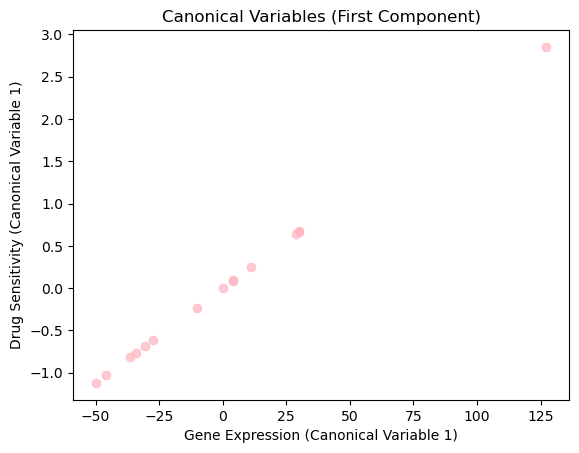

In [8]:
# Initialize and fit CCA
cca = CCA(n_components=min(X.shape[1], Y.shape[1]))  # Number of components
cca.fit(X, Y)

# Transform the datasets
X_c, Y_c = cca.transform(X, Y)

corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]
print(f"Canonical Correlations: {corrs}")

plt.scatter(X_c[:, 0], Y_c[:, 0], alpha=0.7, c="lightpink")
plt.title("Canonical Variables (First Component)")
plt.xlabel("Gene Expression (Canonical Variable 1)")
plt.ylabel("Drug Sensitivity (Canonical Variable 1)")
plt.show()


The result corresponds to the analysis for the whole 5 drugs. A different correlation is expected when isolating the data.

In [11]:
# TODO: Check if X or Y have very low variance - might reduce the meaningful correlations captured by CCA.
# TODO: A value of exactly 1.0 was expected - the first canonical component often represents the strongest possible correlation.

In [13]:
# Transform the datasets into canonical components
X_c, Y_c = cca.transform(X, Y)
n_components = min(X.shape[1], Y.shape[1])
# Compute canonical correlations
correlations = np.corrcoef(X_c.T, Y_c.T)[:n_components, n_components:]
print("Canonical Correlation Coefficients:", np.diag(correlations))


Canonical Correlation Coefficients: [1. 1. 1. 1. 1.]


In [ ]:
# If the sample size is smaller than the number of features in X or Y, the CCA will find relationships that perfectly fit the data?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

pca = PCA(n_components=min(X.shape[0] - 1, X.shape[1]))
X_reduced = pca.fit_transform(X_scaled)
# Y_reduced = pca.fit_transform(Y_scaled)


In [ ]:
from sklearn.model_selection import train_test_split

# To prevent overfitting, we split your dataset into training and testing sets and evaluate the correlations on the test set:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.3, random_state=42)

# Fit CCA on the training data
cca.fit(X_train, Y_train)

# Evaluate on the test data
X_test_c, Y_test_c = cca.transform(X_test, Y_test)
test_correlations = np.corrcoef(X_test_c.T, Y_test_c.T)[:cca.n_components, cca.n_components:]
print("Test Correlations:", np.diag(test_correlations))


In [17]:
print(ccaman.sensitivity_data.head())

  Cell Line    Drug Name   Z Score
0     AU565    Lapatinib -2.583650
1     AU565    Alpelisib -0.925285
2     AU565    Tamoxifen -0.872274
3     AU565  Palbociclib -0.147910
4     AU565     Olaparib  0.179425


In [18]:
print(ccaman.genes_to_cellline.head())

                     184A1      184B5       21MT1       21MT2        21NT  \
EnsEMBL_Gene_ID                                                             
ENSG00000000003  95.212548  95.698676   19.994674   65.686376   44.057746   
ENSG00000001167  89.512619  94.154375  245.433541  216.487072  286.092419   
ENSG00000005471   0.000000   0.172734    0.231762    0.099938    0.000000   
ENSG00000066629  24.701397   7.633869    5.842132    6.773438    5.149179   
ENSG00000154258   0.000000   2.683498    0.000000    0.031877    0.000000   

                       21PT      600MPE      AU565       BT474       BT483  \
EnsEMBL_Gene_ID                                                              
ENSG00000000003   34.317565  178.158832  13.460144   37.879666   69.092581   
ENSG00000001167  289.298295  125.193255  68.907655  167.815672  152.752421   
ENSG00000005471    0.000000    0.757785   2.976117    1.210384    1.670807   
ENSG00000066629    7.432176   29.604076  15.084108   30.669290  135.10

['AU565' 'HCC1143' 'HCC1395' 'HCC1419' 'HCC1428' 'HCC1569' 'HCC1599'
 'HCC18064' 'HCC1937' 'HCC1954' 'HCC202' 'HCC2218' 'HCC38' 'HCC70' 'MCF7'
 'T47D']
